In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 899.3 kB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil
import os
import skimage.io as sk

2024-05-08 02:55:42.662975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 02:55:42.663076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 02:55:42.785105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# List all available models
# timm.list_models("")

In [6]:
# model_name = "timm/vit_base_patch14_reg4_dinov2.lvd142m"
model_name = "timm/maxvit_small_tf_512.in1k"
# model_name = 'timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
from tqdm import tqdm

# Settings
num_epochs = 8
num_accumulate = 4

# Criterion and Metric
criterion = nn.CrossEntropyLoss()
metric = evaluate.load("f1")

In [8]:
train_path = '/kaggle/input/ml-dataset/dataset/training'
val_path = '/kaggle/input/ml-dataset/dataset/validation'
# val_path = '/kaggle/input/ml-dataset/dataset/test'

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

train_batch_size = 8
eval_batch_size = 8

data_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=T.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=data_transforms
)
# validation dataset
valid_dataset = datasets.ImageFolder(
    root=val_path,
    transform=data_transforms
)

# # Function to create a subset consisting of approximately 10% of the dataset
# def sample_subset(dataset, fraction=0.01):
#     total_samples = len(dataset)
#     sampled_indices = np.random.choice(total_samples, int(total_samples * fraction), replace=False)
#     return Subset(dataset, sampled_indices)

# # Create subsets
# train_subset = sample_subset(train_dataset)
# valid_subset = sample_subset(valid_dataset)


train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False)
# train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False)

### EDA

In [10]:
# !pip install stegano

In [11]:
# !pip install jpegio
# import jpegio as jio

In [12]:
# BASE_PATH = "/kaggle/input/ml-dataset/dataset/training"
# train_imageids = pd.Series(os.listdir(BASE_PATH + '/cover')).sort_values(ascending=True).reset_index(drop=True)

In [13]:
# BASE_PATH = "/kaggle/input/ml-dataset/dataset/training"
# cover_images_path = pd.Series(BASE_PATH + '/cover/' + train_imageids ).sort_values(ascending=True)
# JMIPOD_images_path = pd.Series(BASE_PATH + '/jmipod/'+train_imageids).sort_values(ascending=True)
# JUNIWARD_images_path = pd.Series(BASE_PATH + '/juniward/'+train_imageids).sort_values(ascending=True)
# UERD_images_path = pd.Series(BASE_PATH + '/uerd/'+train_imageids).sort_values(ascending=True)

In [14]:
# fig,ax = plt.subplots(4,4,figsize=(20,16))
# plt.tight_layout()


# im1 = Image.open(cover_images_path[0])
# im2 = Image.open(JUNIWARD_images_path[0])
# im3 = Image.open(JMIPOD_images_path[0])
# im4 = Image.open(UERD_images_path[0])

# for i,image in enumerate([im1,im2,im3,im4]):
#     ycbcr = image.convert('YCbCr')
#     (y, cb, cr) = ycbcr.split()

#     ax[i,0].imshow(image)
#     ax[i,0].set_title('Image')
#     ax[i,1].imshow(y)
#     ax[i,1].set_title('Luminance')
#     ax[i,2].imshow(cb)
#     ax[i,2].set_title('Cb:Chroma Blue')
#     ax[i,3].imshow(cr)
#     ax[i,3].set_title('Cr:Chroma Red')

In [15]:
# coverDCT = np.zeros([512,512,3])
# stegoDCT = np.zeros([512,512,3])
# jpeg = jio.read(cover_images_path[0])
# stego_juni = jio.read(JUNIWARD_images_path[0])

In [16]:
# coverDCT[:,:,0] = jpeg.coef_arrays[0] ; coverDCT[:,:,1] = jpeg.coef_arrays[1] ; coverDCT[:,:,2] = jpeg.coef_arrays[2]
# stegoDCT[:,:,0] = stego_juni.coef_arrays[0] ; stegoDCT[:,:,1] = stego_juni.coef_arrays[1] ; stegoDCT[:,:,2] = stego_juni.coef_arrays[2]

# DCT_diff = coverDCT - stegoDCT
# # So since they are not the same Images the DCT_diff would not be zero
# print(len(DCT_diff[np.where(DCT_diff!=0)]))
# print(np.unique(DCT_diff))
# plt.figure(figsize=(16,10))
# plt.imshow( abs(DCT_diff) )
# plt.show()

In [17]:
# coverPixels = np.array(Image.open(cover_images_path[0])).astype('float')
# stegoPixels = np.array(Image.open(JUNIWARD_images_path[0])).astype('float')

# pixelsDiff = coverPixels - stegoPixels

# # So since they are not the same Images the pixels_diff would not be zero
# print(len(pixelsDiff[np.where(pixelsDiff!=0)]))
# print(np.unique(pixelsDiff))
# plt.figure(figsize=(16,10))
# plt.imshow( abs(pixelsDiff) )
# plt.show()

In [18]:
# fig,ax = plt.subplots(1,2,figsize=(16,12))
# ax[0].imshow(abs(DCT_diff))
# ax[1].imshow(abs(pixelsDiff))

In [19]:
# # Check the first few batches
# for inputs, targets in train_dataloader:
#     print("Sample inputs size:", inputs.size())
#     print("Sample targets:", targets)
#     break

0


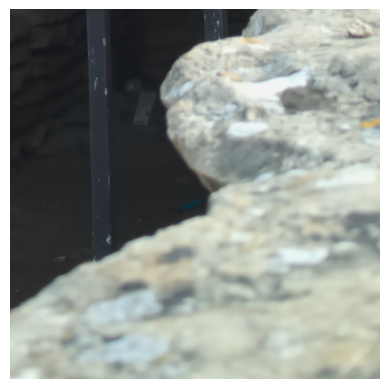

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    to_image = T.ToPILImage()
    img = to_image(tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

img_tensor, label = train_dataset[0]
print(label)
show_image(img_tensor)

## Training

In [21]:
# Model, Optimizer, and Scheduler
model = timm.create_model(model_name, pretrained=True, num_classes=4)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

model.safetensors:   0%|          | 0.00/277M [00:00<?, ?B/s]

Using 2 GPUs!


In [22]:
from sklearn import metrics
import numpy as np

def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization

In [23]:
optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)

scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]


for epoch in range(num_epochs):
    model.train()
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    train_preds = []
    train_targets = []
    
    val_preds = []
    val_targets = []
    
    num_updates = epoch * len(train_dataloader)
    
    best_auc = None 
    
    y_pred = []

    # Training Loop
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        
        loss.backward()

        if ((batch_idx + 1) % num_accumulate == 0) or (batch_idx + 1 == len(train_dataloader)):
            optimizer.step()
            scheduler.step_update(num_updates=num_updates)
            optimizer.zero_grad()

        train_loss_epoch.append(loss.item())
        train_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
        train_targets.extend(targets.tolist())
        
    optimizer.sync_lookahead()
    scheduler.step(epoch + 1)

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            val_loss_epoch.append(loss.item())
            
            val_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
            val_targets.extend(targets.tolist())
            
            
            y_pred.extend(1 - torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 0])
            

    # Calculate Metrics
    metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
    metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]
    
    
    auc_score = alaska_weighted_auc(val_targets, y_pred)
    
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(val_loss_epoch)}, Train F1 {metric_train}, Val F1 {metric_val}, AUC weight score {auc_score}")
    
    # Best Model Check
    if best_auc == None:
        best_auc = auc_score
        if torch.cuda.current_device() == 0:
            torch.save(model, f"best_model_{model_name[5::]}_{epoch+1}_epoch.pt")
        continue
        
    if auc_score > best_auc:
        best_auc = auc_score
        if torch.cuda.current_device() == 0:
            torch.save(model, f"best_model_{model_name[5::]}_{epoch+1}_epoch.pt")

100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s]


Epoch 1: Train Loss 1.2898082622289657, Val Loss 1.1430669729411602, Train F1 0.339502175582076, Val F1 0.40029427944457197, AUC weight score 0.40882586309523805


100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


Epoch 2: Train Loss 1.114636537373066, Val Loss 1.1005733651784249, Train F1 0.4568382832131254, Val F1 0.4293906711041089, AUC weight score 0.3775954761904761


100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


Epoch 3: Train Loss 1.0428065244810922, Val Loss 1.0404181567132473, Train F1 0.48530214070323763, Val F1 0.42248407606731453, AUC weight score 0.3759281845238097


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 4: Train Loss 0.990329607129097, Val Loss 0.9790930921686813, Train F1 0.5029264641276897, Val F1 0.4981081873198235, AUC weight score 0.345713125


100%|██████████| 1000/1000 [07:04<00:00,  2.35it/s]


Epoch 5: Train Loss 0.9451252997517586, Val Loss 0.9526341941627324, Train F1 0.5174569944188452, Val F1 0.45315437139253634, AUC weight score 0.33403053571428576


100%|██████████| 1000/1000 [06:59<00:00,  2.39it/s]


Epoch 6: Train Loss 0.8936807846852711, Val Loss 0.9469711349254357, Train F1 0.5340402121336327, Val F1 0.46040120870980483, AUC weight score 0.32768068452380955


100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


Epoch 7: Train Loss 0.8510792941536223, Val Loss 0.9271524770533579, Train F1 0.5562074504273147, Val F1 0.4918998072271964, AUC weight score 0.3243292261904763


100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


Epoch 8: Train Loss 0.8175342323865209, Val Loss 0.93958055597161, Train F1 0.5644258039763468, Val F1 0.5168395938681379, AUC weight score 0.32458169642857143


## Evaluation

Evaluating: 100%|██████████| 500/500 [03:53<00:00,  2.14it/s]


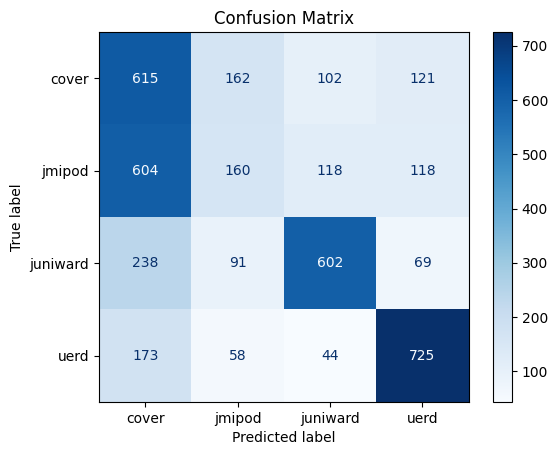

              precision    recall  f1-score   support

       cover       0.38      0.61      0.47      1000
      jmipod       0.34      0.16      0.22      1000
    juniward       0.70      0.60      0.65      1000
        uerd       0.70      0.72      0.71      1000

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.51      4000
weighted avg       0.53      0.53      0.51      4000



In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# Path to the validation dataset and model
test_path = '/kaggle/input/ml-dataset/dataset/test'

model_path = "/kaggle/input/image_stega/pytorch/maxvit_small_tf_512.in1k_5_epoch/1/best_model_maxvit_small_tf_512.in1k_5_epoch.pt"

# Device configuration (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations used for the validation data
data_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

# Load the dataset using the specified transformations
test_dataset = datasets.ImageFolder(
    root=test_path,
    transform=data_transforms
)

# Create a data loader for the validation dataset
test_batch_size = 8
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Load the trained model
# loaded_model = torch.load(model_path)
loaded_model = model
loaded_model.to(device)
loaded_model.eval()

# Initialize lists for predictions and references (actual labels)
predictions = []
references = []
y_pred = []

# Disable gradient calculation for prediction
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # Get inputs and targets from the batch
        inputs, targets = batch
        inputs = inputs.to(device)
        
        # Run the inputs through the model to get predictions
        outputs = loaded_model(inputs)
        
        # Determine the predicted class for each sample
        preds = outputs.argmax(dim=-1)
        
        # Append predictions and actual labels to the respective lists
        predictions.extend(preds.cpu().tolist())
        references.extend(targets.tolist())
        y_pred.extend(1 - torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 0])

# Compute the confusion matrix using the actual and predicted labels
cm = confusion_matrix(references, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot and display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate a classification report for accuracy, precision, recall, and F1 score
report = classification_report(references, predictions, target_names=test_dataset.classes)
print(report)


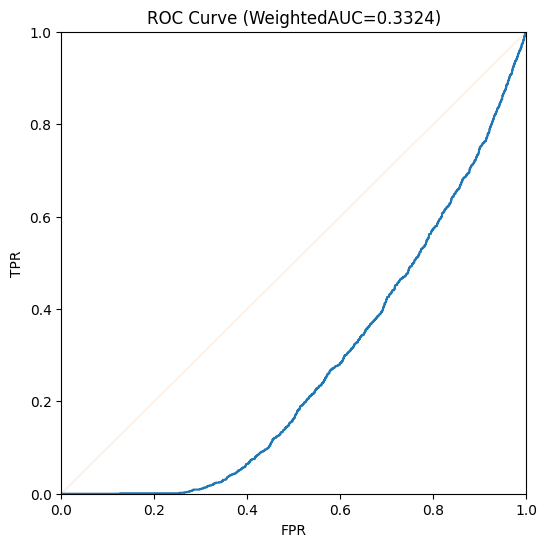

Weighted AUC:  0.33244785714285713


In [25]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(references, y_pred, pos_label=1)

weighted_auc = alaska_weighted_auc(references, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (WeightedAUC={round(weighted_auc, 4)})')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], alpha=0.1)
plt.show()

print("Weighted AUC: ",weighted_auc)

## Submission

In [26]:
# from torchvision import datasets, transforms

# test_files = glob.glob("/kaggle/input/alaska2-image-steganalysis/Test/*.jpg")

# data_transforms = transforms.Compose([
#     transforms.Resize((512, 512)),
#     transforms.ToTensor(),
# ])

# test_dataloader = ImageDataset("/kaggle/input/alaska2-image-steganalysis/Test", transform=data_transforms)

In [27]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [28]:
# answers_final = dict()

# loaded_model = torch.load(f"/kaggle/input/image_stega/pytorch/maxvit_small_tf_512.in1k_5_epoch/1/best_model_maxvit_small_tf_512.in1k_5_epoch.pt")

# model = loaded_model

# model.eval()

# with torch.no_grad():
#     for f in tqdm(test_files):
#         key = f.split("/")[-1].split(".")[0]
#         img = Image.open(f).convert("RGB")
        
#         transformed = data_transforms(img).unsqueeze(0).to(device)
#         y_pred = model(transformed)
#         y_pred = 1 - torch.nn.functional.softmax(y_pred, dim=1).cpu().numpy()[:, 0]

#         answers_final[key] = y_pred.tolist() 

In [29]:
# submission = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')

In [30]:
# for file_id, label in answers_final.items():
#     file_name = f'{file_id}.jpg'
#     if file_name in submission['Id'].values:
#         submission.loc[submission['Id'] == file_name, 'Label'] = label[0]

# # Save the updated submission file
# submission.to_csv('updated_submission.csv', index=False)

# print("Updated submission file is saved as 'updated_submission.csv'.")